# Facial Detection

###IMPORTANT: Before running anything, please change your runtime type to a GPU! (Select Runtime --> Change Runtime Type --> T4GPU)

In this hackpack, we're going to explore the problem of facial detection: classifying images as either faces or non-faces. This is something that technology all around you does every day-- your lock screen and security cameras are just a few examples! You're going to develop a Convolutional Neural Network (CNN, don't worry if you don't know what that is yet!) that takes in an image and outputs whether or not it is a face. We're also going to take a look into the potential biases that could impact this model, and figure out ways to overcome them.

The following was curriculum develop by [Harvard and MIT Momentum AI](https://momentumai.org/); the code and method is adapted from [Amini et al. AIES 2019](https://dl.acm.org/doi/pdf/10.1145/3306618.3314243), and [MIT's Introduction to Deep Learning Class](http://introtodeeplearning.com/).


## Section 1: Readings & Resources
Before we actually train a model and inspect data, we will recommend some articles and videos that will give us some background info about facial detection, its uses, and its dangers. As with all machine learning tools, it is important to understand how our tool will impact its users:
* [A Gentle Introduction to Deep Learning for Face Recognition](https://machinelearningmastery.com/introduction-to-deep-learning-for-face-recognition/)
* [Joy Buolamwini's Research on the Coded Gaze](https://www.ted.com/talks/joy_buolamwini_how_i_m_fighting_bias_in_algorithms)
* [New York Times Article about Bias in Facial Detection](https://drive.google.com/drive/folders/1FH9-Bgo9G8tDey_VVvNGnUYpsi8Eq3To)

##Section 2: Building Our Own Facial Detection Classifier

Now that you know a little more on the history and biases in facial detection classifiers, let's build our own classifier! As you go through this class, you'll learn more and more about different types of neural networks and how to apply them to different data. So don't be alarmed if you don't know what any of the code or following sections mean! We'll go through examples in more detail.



Let's start by importing all the libraries we need

In [ ]:
import tensorflow as tf
import IPython
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import h5py
import sys
import gc


##2.1: Data

In this section, we'll dive deeper into the dataset we'll be using throughout this lab.

In order to train our facial detection models, we will need a dataset of faces and a dataset of things that are not faces. For our positive training data, or faces, we'll use the CelebA Dataset, a large dataset of celebrity faces, and for the non-faces, we'll pull examples from **ImageNet**, one of the most popular image datasets with many different categories. We will take negative examples from a variety of non-human categories.

We will evaluate trained models on an independent test dataset of face images to diagnose potential issues with bias, fairness, and confidence.


Let's first download the data that we're going to be using throughout this lab:

In [ ]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('data_float16.h5', 'https://www.dropbox.com/scl/fi/8hab37jvnrkgpcigwn3le/data_float16.h5?rlkey=u8gsp4dprux7i8d7i5vr8dkwn&dl=1')
cache = h5py.File(path_to_training_data, 'r') # reads the data from a file into our memory
print ("Loading data into memory...")
sys.stdout.flush()
images = cache['images'][:] # get all the images from our dataset
labels = cache['labels'][:] # get all the labels of the dataset

# Now, let's divide the dataset into faces and non-faces based on the label
image_dims = images.shape
n_train_samples = image_dims[0] # the first dimension (remember that everything in CS indexes starting at 0!) tells us how many samples we have
train_inds = np.arange(n_train_samples) # let's look at the images in order

pos_inds = train_inds[ labels[train_inds, 0] == 1.0 ] # these are the indices, or locations, of all the faces in the dataset
neg_inds = train_inds[ labels[train_inds, 0] != 1.0 ] # and these are the non-faces in the dataset!

2701468340/2701468340 [==============================] - 36s 0us/step
Loading data into memory...


In [ ]:
print(image_dims) # (num images, width , height, color_channels)

(109914, 64, 64, 3)


##2.2: Data Visualization
Let's write a function to display 5 faces and 5 non-faces from our dataset to give you a better idea of what the dataset looks like!

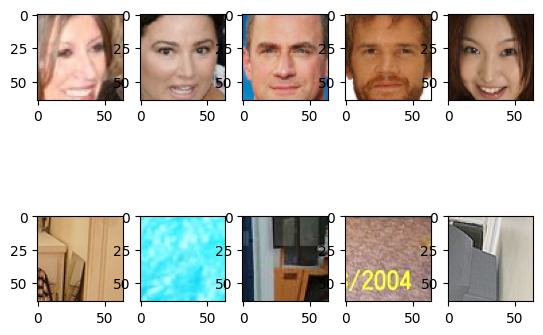

In [ ]:
positive_indices_to_plot = pos_inds[:5]# grab the first 5 elements from the positive train indices we defined above
negative_indices_to_plot = neg_inds[:5]# do the same but with the negative indices!
faces_to_plot = images[positive_indices_to_plot].astype(int) # This grabs all of the faces that we want
negatives_to_plot = images[negative_indices_to_plot].astype(int)
fig, axs = plt.subplots(2, 5) # This creates a plotter with two rows and five columns to hold our data

for idx in range(5):
  # Previously, we only grabbed the indices, or locations, of the faces and non-faces we want to plot. But now we want the actual images!
  face_to_plot = faces_to_plot[idx] # index into the array of images we defined above
  negative_to_plot = negatives_to_plot[idx] # index into the array of negatives we defined above
  axs[0][idx].imshow(face_to_plot[:,:,::-1])
  axs[1][idx].imshow(negative_to_plot[:,:,::-1])

plt.show() #This actually shows the figure: you should see a row of faces and a row of objects!

Now that you've seen what the images look like, let's plot the **frequencies** of the data in the dataset. Figure out how many faces we have, and how many non faces, and represent this in a graph!

Text(0.5, 1.0, 'positive faces(n=53957) and negative faces((n=55957))')

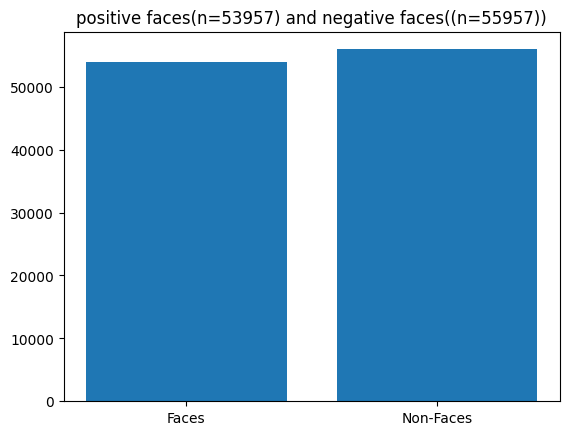

In [ ]:
number_of_faces = len(pos_inds)# store the number of positive indices here-- that's how many faces we have!
number_of_non_faces = len(neg_inds)# store the number of negative indices here-- that's how many non-faces we have!

plt.bar(["Faces", "Non-Faces"], [number_of_faces, number_of_non_faces])#TODO: fill in the correct variables here in the correct format to create a bar plot! check out the matplotlib documentation https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html)
plt.title(f"positive faces(n={number_of_faces}) and negative faces((n={number_of_non_faces}))")

**Written exercise:** Note down what you notice about the plot you just made. What do you think this implies for training? Why? Is this a good thing or a bad thing?

##2.3: Data Pipeline

We have the *indices*, or *locations* of the positive and negative training examples, but we need to create one big array of examples to pass to the Keras training utiltiies. Let's do that below. We'll use 70% of the dataset to train the model, and 30% to test the model. This ratio is usually good because we want to check if after training, the model can **generalize** to unseen data, which comes from the **test set**.

In [ ]:
number_of_training_positive_indices = 0.7 * number_of_faces # Define this to be seventy percent of the number of faces in the dataset
number_of_training_negative_indices = 0.7 * number_of_non_faces # Define this to be seventy percent of the number of non-faces in the dataset

training_positive_indices = pos_inds[:int(number_of_training_positive_indices)]# grab the first seventy percent of the variable storing all of the positive indices. Hint: google "list slicing python"
training_negative_indices = neg_inds[:int(number_of_training_negative_indices)]# grab the first seventy percent of the variable storing all of the negative indices. Hint: google "list slicing python"

testing_positive_indices = pos_inds[int(number_of_training_positive_indices) : ]# grab the last thirty percent of the variable storing all of the positive indices. Hint: google "list slicing python"
testing_negative_indices = neg_inds[int(number_of_training_negative_indices) : ]# grab the last thirty percent of the variable storing all of the negative indices. Hint: google "list slicing python"

all_training_indices = np.concatenate((training_positive_indices, training_negative_indices))# concatenate the two training lists you just made to create a new list of all the indices. Google "numpy concatenate" if you need help!
all_testing_indices = np.concatenate((testing_positive_indices, testing_negative_indices))# concatenate the two testing lists you just made to create a new list of all the indices. Google "numpy concatenate" if you need help!

training_images = images[all_training_indices] # This now grabs all the training images we want out of the initial array
training_labels = labels[all_training_indices] # This now grabs all the training labels we want out of the initial array

testing_images = images[all_testing_indices] # This now grabs all the testing images we want out of the initial array
testing_labels = labels[all_testing_indices] # This now grabs all the testing labels we want out of the initial array

# let's store these in a dataset object; don't worry if you don't know what this is!
train_dataset = tf.data.Dataset.from_tensor_slices((training_images, training_labels))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

# Makes sure we don't run out of memory :')
del images
del labels
gc.collect()


24608

#Section 3: Creating a Standard CNN

Now that you know what the data looks like and how it's distributed, let's train a model on it! This model uses BatchNormalization layers, which you probably haven't seen before. They essentially help normalize outputs of layers to make learning data much easier!

In [ ]:
### Define the CNN model ###

n_filters = 12# number of convolutional filters to use, play around with this number!

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):

  model = tf.keras.Sequential([ # Add more layers here or remove layers or play with hyperparameters to achieve the best performance!
    tf.keras.layers.Conv2D(filters=1*n_filters, kernel_size=5,  strides=2, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=2*n_filters, kernel_size=5,  strides=2, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=4*n_filters, kernel_size=5,  strides=2, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    # tf.keras.layers.Conv2D(filters=6*n_filters, kernel_size=5,  strides=2, activation='relu', padding='same'),
    # tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dense(n_outputs, activation='sigmoid'),
  ])
  return model

standard_classifier = make_standard_classifier()

Let's now train the CNN on the data!

In [ ]:
# Makes sure we don't run out of memory :')
class Callback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(Callback, self).__init__()

    def on_epoch_end(self, epoch: int, logs=None):
        # Housekeeping
        gc.collect()
        tf.keras.backend.clear_session()

In [ ]:
#  use the `model.compile` and `model.fit` functions to train the CNN you just created on this data
standard_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),# experiment with learning rate!
    loss='binary_crossentropy',
    metrics='accuracy',
)
history = standard_classifier.fit(train_dataset,
                        epochs= 5,# experiment with epochs!
                        callbacks=[Callback()])

Epoch 1/5
1203/1203 [==============================] - 27s 9ms/step - loss: 0.0139 - accuracy: 0.9973
Epoch 2/5
1203/1203 [==============================] - 12s 10ms/step - loss: 0.1179 - accuracy: 0.9917
Epoch 3/5
1203/1203 [==============================] - 15s 12ms/step - loss: 0.0687 - accuracy: 0.9928
Epoch 4/5
1203/1203 [==============================] - 10s 8ms/step - loss: 0.0209 - accuracy: 0.9964
Epoch 5/5
1203/1203 [==============================] - 8s 7ms/step - loss: 0.0058 - accuracy: 0.9986


Text(0.5, 1.0, 'Training loss over epochs')

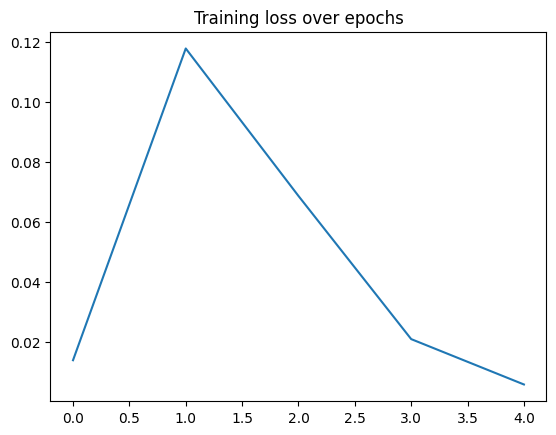

In [ ]:
plt.plot(history.history['loss'])
plt.title("Training loss over epochs")

Evaluate the CNN on the test set we defined earlier!

In [ ]:
print(training_images.shape) # this is what we are feeding into training
print(testing_images.shape) # this is what we are feeding into test

(76938, 64, 64, 3)
(32976, 64, 64, 3)


In [ ]:
# use the `model.predict` function to evaluate the CNN on the test set.
results = standard_classifier(testing_images, training=False) # TODO: call the model on the array of `testing_images`
accuracy = np.round(results)
print("Test set accuracy", np.mean(accuracy == testing_labels))

Test set accuracy 0.8187772925764192


What did you notice about the test set accuracy? If it's lower than you expect from the training data accuracy, your model might be **overfitting**. Google some methods to combat this! Hint: you should try decreasing your learning rate or the number of epochs you train for :)

(1, 64, 64, 3)
1/1 [==============================] - 0s 53ms/step
(1, 64, 64, 3)
1/1 [==============================] - 0s 54ms/step
(1, 64, 64, 3)
1/1 [==============================] - 0s 50ms/step
(1, 64, 64, 3)
1/1 [==============================] - 0s 63ms/step
(1, 64, 64, 3)
1/1 [==============================] - 0s 47ms/step


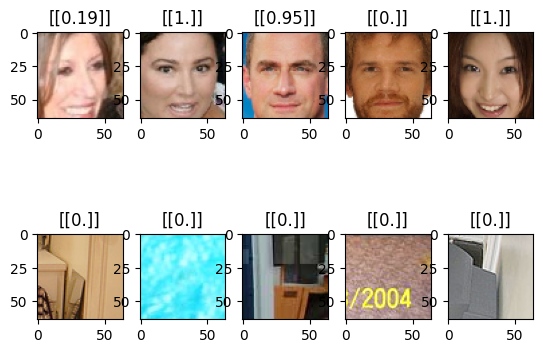

In [ ]:
# earlier, we plotted five images of each class. Let's see what the model predicts for this same set of images

fig, axs = plt.subplots(2, 5) # This creates a plotter with two rows and five columns to hold our data

for idx in range(5):
  # These will pull up the same images as earlier: let's title every image with the model prediction.
  face_to_plot = faces_to_plot[idx]
  face_to_plot = np.expand_dims(face_to_plot, axis=0)
  print(face_to_plot.shape)
  face_prediction = standard_classifier.predict(face_to_plot) # Call the model.predict function on the `face_to_plot` image here!

  gc.collect()
  tf.keras.backend.clear_session()
  face_prediction = np.round(face_prediction, 2)

  negative_to_plot = negatives_to_plot[idx]
  negative_to_plot = np.expand_dims(negative_to_plot, axis=0)
  negative_prediction = standard_classifier.predict(negative_to_plot) # Call the model.predict function on the `negative_to_plot` image here!

  gc.collect()
  tf.keras.backend.clear_session()
  negative_prediction = np.round(negative_prediction, 2)

  axs[0][idx].title.set_text(str(face_prediction))
  axs[0][idx].imshow(face_to_plot[0, :, :, ::-1].astype(int))
  axs[1][idx].imshow(negative_to_plot[0, :, :, ::-1].astype(int))
  axs[1][idx].title.set_text(str(negative_prediction))

plt.show() #This actually shows the figure: you should see a row of faces and a row of objects!

Congratulations! You just created your first facial detection network. Your neural network should classify faces as label closer to 1, and non-faces closer to 0. How did your neural network do?

Some things to think about here: do you expect this network to work well on faces from all demographics? Based on the articles you read, when do you think this model will fail? How would you go about fixing this issue?

# Section 4: Experimenting with Your Webcam!

In this section, you will try taking pictures with your own webcam!

For reference, much of this code is adapted from [this online tutorial](https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing)

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from google.colab.patches import cv2_imshow

import cv2
import PIL
import io
import html
import time

### Helper Functions
Below are a few helper function to make converting between different image data types and formats. In addition, we include the `center_square_crop` and `scale_image` helper functions to help us scale down the image to the right size.

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def center_square_crop(img):
  """Returns center cropped image
	Args:
	img: image to be center cropped
	dim: dimensions (width, height) to be cropped
	"""
  width, height = img.shape[1], img.shape[0]
  dim = (min(width, height), min(width, height))

	# process crop width and height for max available dimension
  crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
  crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0]
  mid_x, mid_y = int(width/2), int(height/2)
  cw2, ch2 = int(crop_width/2), int(crop_height/2)
  crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
  return crop_img

In [ ]:
def scale_image(img, dim=64):
	"""Returns resize image, scaled to a square of size dim
	Args:
	img: image to be scaled
	dim: size of side of square
	"""
	return cv2.resize(img, (dim, dim))

### Haar Cascade Classifier
To help us capture faces, we have the option of running a simple object detection algorithm called Haar Cascade on our images and video fetched from our webcam. OpenCV has a pre-trained Haar Cascade face detection model. Note, using this is optional

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

## Take Photo
Run the next two cells to take a photo. Make sure to fill out `filename` to give your image a name!

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8, crop_face=False):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      // display square
      // square = Math.min(video.width, video.height)
      // video.width = square
      // video.height = square
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  if crop_face:
    # grayscale img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    print(gray.shape)
    # get face bounding box coordinates using Haar Cascade
    faces = face_cascade.detectMultiScale(gray)
    # draw face bounding box on image
    for (x,y,w,h) in faces:
        # img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        img = img[y: y+h, x:x+w]
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


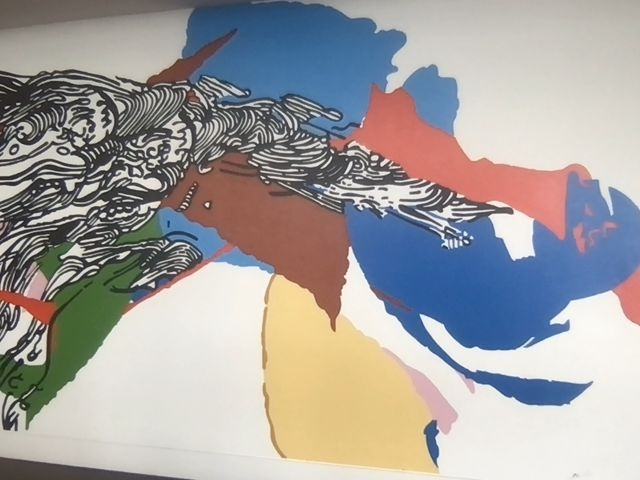

In [ ]:
filestr = 'photo' #TODO fill this out

try:
  filename = take_photo(f'{filestr}.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

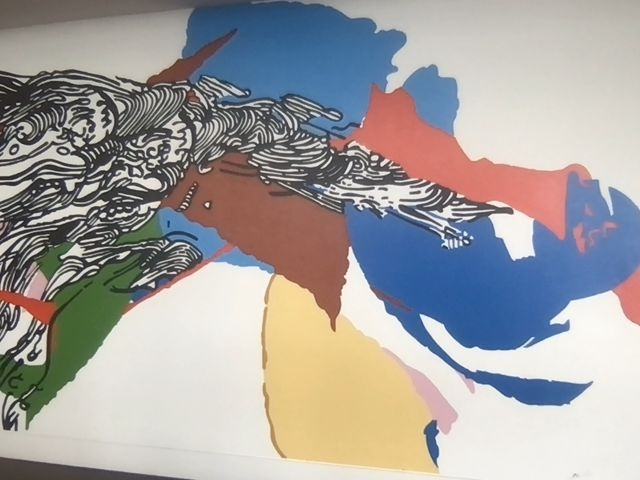

In [ ]:
image = cv2.imread(filename)
# show the image, provide window name first
cv2_imshow(image)
# add wait key. window waits until user presses a key
cv2.waitKey(0)
# and finally destroy/close all open windows
cv2.destroyAllWindows()

## Process Image and Feed It Into Neural Net

First, we will crop the image into a square, and then scale it to the right size to feed into our model.

Finally, we will plot and run our model on our own images! Remember, the closer the prediction to 1, to more your neural network thinks you are showing it a face. Try it yourself, and test how well your neural network is able to classify your images.

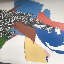

In [ ]:
# process image
processed_image = scale_image(center_square_crop(image))
cv2_imshow(processed_image)

(1, 64, 64, 3)
1/1 [==============================] - 0s 56ms/step


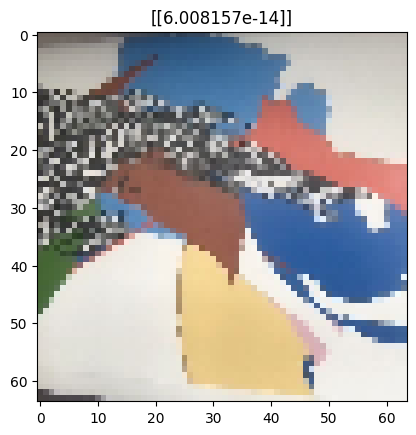

In [ ]:
face_to_plot = np.expand_dims(processed_image, axis=0)
print(face_to_plot.shape)
face_prediction = standard_classifier.predict(face_to_plot) # Call the model.predict function on the `face_to_plot` image here!

gc.collect()
tf.keras.backend.clear_session()

plt.title(str(face_prediction))
plt.imshow(face_to_plot[0, :, :, ::-1].astype(int))

How well did your model do? Did you notice any biases? Does your model do better on certain types of images than others?

# Save Your Model
You can save your Tensorflow model as a `.keras` zip file with `model.save("pathname")`, and load it later with `model.load_model("pathname")`

In [39]:
# Show the model architecture
standard_classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 12)        912       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 12)        48        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 24)        7224      
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 24)        96        
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 48)          28848     
                                                                 
 batch_normalization_2 (Bat  (None, 8, 8, 48)          1

In [40]:
# Save the entire model as a `.keras` zip archive.
standard_classifier.save('my_classifier.keras')

In [41]:
new_model = tf.keras.models.load_model('my_classifier.keras')

# Show the new model architecture, should be same as above
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 12)        912       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 12)        48        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 24)        7224      
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 24)        96        
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 48)          28848     
                                                                 
 batch_normalization_2 (Bat  (None, 8, 8, 48)          1